In [1]:
from pyomo.environ import (Constraint,
                           Var,
                           ConcreteModel,
                           Expression,
                           Param,
                           Objective,
                           SolverFactory,
                           TransformationFactory,
                           value)

from pyomo.network import Arc, SequentialDecomposition

from idaes.core.util.initialization import propagate_state

# Import plotting functions
import matplotlib.pyplot as plt

# Import numpy library 
import numpy as np

# Import the main FlowsheetBlock from IDAES. The flowsheet block will contain the unit model
from idaes.core import FlowsheetBlock

import idaes.logger as idaeslog
from pyomo.opt import TerminationCondition, SolverStatus

# Import the degrees_of_freedom function from the idaes.core.util.model_statistics package
# DOF = Number of Model Variables - Number of Model Constraints
from idaes.core.util.model_statistics import degrees_of_freedom

# Import the Generic Parameter Block
from idaes.generic_models.properties.core.generic.generic_property import (
        GenericParameterBlock)

# Import unit models from the model library
from idaes.generic_models.unit_models import Flash

# Import R32, R125, IL info file
from HFCs_bmimBF4_PR import configuration


In [2]:
m1 = ConcreteModel()

m1.fs = FlowsheetBlock(default={"dynamic": False})

m1.fs.properties = GenericParameterBlock(default=configuration)

m1.fs.F101 = Flash(default={"property_package": m1.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

m2 = ConcreteModel()

m2.fs = FlowsheetBlock(default={"dynamic": False})

m2.fs.properties = GenericParameterBlock(default=configuration)

m2.fs.F101 = Flash(default={"property_package": m2.fs.properties,
                           "has_heat_transfer": True,
                           "has_pressure_change": True})

# m3 = ConcreteModel()

# m3.fs = FlowsheetBlock(default={"dynamic": False})

# m3.fs.properties = GenericParameterBlock(default=configuration)

# m3.fs.F101 = Flash(default={"property_package": m3.fs.properties,
#                            "has_heat_transfer": True,
#                            "has_pressure_change": True})



In [3]:
m1.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.009)
m1.fs.properties.PR_kappa_A['R125', 'R32'].fix(0.007)
m1.fs.properties.PR_kappa_A['R32', 'bmimBF4'].fix(-0.00684)
m1.fs.properties.PR_kappa_A['bmimBF4', 'R32'].fix(-0.02825)
m1.fs.properties.PR_kappa_A['bmimBF4', 'R125'].fix(0.57152)
m1.fs.properties.PR_kappa_A['R125', 'bmimBF4'].fix(0.06453)

# m2.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.009)
# m2.fs.properties.PR_kappa_A['R125', 'R32'].fix(0.007)
# m2.fs.properties.PR_kappa_A['R32', 'bmimBF4'].fix(-0.02664)
# m2.fs.properties.PR_kappa_A['bmimBF4', 'R32'].fix(-0.34939)
# m2.fs.properties.PR_kappa_A['bmimBF4', 'R125'].fix(1.06456)
# m2.fs.properties.PR_kappa_A['R125', 'bmimBF4'].fix(0.060355)

m2.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.465694)
m2.fs.properties.PR_kappa_A['R125', 'R32'].fix(0.03704)
m2.fs.properties.PR_kappa_A['R32', 'bmimBF4'].fix(-0.01840)
m2.fs.properties.PR_kappa_A['bmimBF4', 'R32'].fix(0.05568)
m2.fs.properties.PR_kappa_A['bmimBF4', 'R125'].fix(0.40394)
m2.fs.properties.PR_kappa_A['R125', 'bmimBF4'].fix(0.05356)

# m3.fs.properties.PR_kappa_A['R32', 'R125'].fix(0.39255)
# m3.fs.properties.PR_kappa_A['R125', 'R32'].fix(-0.375437)
# m3.fs.properties.PR_kappa_A['R32', 'bmimPF6'].fix(0.06399)
# m3.fs.properties.PR_kappa_A['bmimPF6', 'R32'].fix(0.63257)
# m3.fs.properties.PR_kappa_A['bmimPF6', 'R125'].fix(-1.195988)
# m3.fs.properties.PR_kappa_A['R125', 'bmimPF6'].fix(-0.088142)
# m3.fs.properties.PR_kappa_B['R32', 'R125'].fix(-0.389117)
# m3.fs.properties.PR_kappa_B['R125', 'R32'].fix(0.3892)
# m3.fs.properties.PR_kappa_B['R32', 'bmimPF6'].fix(-0.10862)
# m3.fs.properties.PR_kappa_B['bmimPF6', 'R32'].fix(-0.69149)
# m3.fs.properties.PR_kappa_B['bmimPF6', 'R125'].fix(1.5687447)
# m3.fs.properties.PR_kappa_B['R125', 'bmimPF6'].fix(0.084894)

In [4]:
solver = SolverFactory('ipopt')
solver.options = {'tol': 1e-6}

In [5]:
# Set pressures to loop over
R125_z = [0.01, 0.1, 0.3, 0.5, 0.6, 0.7, 0.99]

# Make outlet arrays
IL_x = np.zeros(len(R125_z))
IL_y = np.zeros(len(R125_z))
R32_x = np.zeros(len(R125_z))
R32_y = np.zeros(len(R125_z))
R125_x = np.zeros(len(R125_z))
R125_y = np.zeros(len(R125_z))

IL_x2 = np.zeros(len(R125_z))
IL_y2 = np.zeros(len(R125_z))
R32_x2 = np.zeros(len(R125_z))
R32_y2 = np.zeros(len(R125_z))
R125_x2 = np.zeros(len(R125_z))
R125_y2 = np.zeros(len(R125_z))

IL_x3 = np.zeros(len(R125_z))
IL_y3 = np.zeros(len(R125_z))
R32_x3 = np.zeros(len(R125_z))
R32_y3 = np.zeros(len(R125_z))
R125_x3 = np.zeros(len(R125_z))
R125_y3 = np.zeros(len(R125_z))
L3 = np.zeros(len(R125_z))
V3 = np.zeros(len(R125_z))

m1.fs.F101.inlet.flow_mol.fix(10)
m1.fs.F101.inlet.temperature.fix(298)
m1.fs.F101.inlet.mole_frac_comp[0, "bmimBF4"].fix(0.5) 
m1.fs.F101.inlet.pressure.fix(250000)

m2.fs.F101.inlet.flow_mol.fix(10)
m2.fs.F101.inlet.temperature.fix(298)
m2.fs.F101.inlet.mole_frac_comp[0, "bmimBF4"].fix(0.9) 
m2.fs.F101.inlet.pressure.fix(250000)

# m3.fs.F101.inlet.flow_mol.fix(10)
# m3.fs.F101.inlet.temperature.fix(298)
# m3.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.9) 
# m3.fs.F101.inlet.pressure.fix(100000)

m1.fs.F101.vap_outlet.pressure.fix(250000)
m1.fs.F101.vap_outlet.temperature.fix(298.15)
m2.fs.F101.vap_outlet.pressure.fix(250000)
m2.fs.F101.vap_outlet.temperature.fix(298.15)
# m3.fs.F101.vap_outlet.pressure.fix(100000)
# m3.fs.F101.vap_outlet.temperature.fix(298.15)


m1.fs.liq = Param(mutable=True, default=0.3)
m2.fs.liq = Param(mutable=True, default=0.3)
# m3.fs.liq = Param(mutable=True, default=0.3)

for i in range(len(R125_z)):
    
    m1.fs.F101.inlet.flow_mol.fix(10)
    m1.fs.F101.inlet.temperature.fix(298)
    m1.fs.F101.inlet.mole_frac_comp[0, "bmimBF4"].fix(0.87) 
    m1.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.13*R125_z[i]) 
    m1.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.13*(1-R125_z[i]))
    
    m1.fs.F101.inlet.pressure.fix(250000)

    m2.fs.F101.inlet.flow_mol.fix(10)
    m2.fs.F101.inlet.temperature.fix(298)
    m2.fs.F101.inlet.mole_frac_comp[0, "bmimBF4"].fix(0.87) 
    m2.fs.F101.inlet.pressure.fix(250000)
    m2.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.13*R125_z[i]) 
    m2.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.13*(1-R125_z[i]))

#     m3.fs.F101.inlet.flow_mol.fix(10)
#     m3.fs.F101.inlet.temperature.fix(298)
#     m3.fs.F101.inlet.mole_frac_comp[0, "bmimPF6"].fix(0.7) 
#     m3.fs.F101.inlet.pressure.fix(100000)
#     m3.fs.F101.inlet.mole_frac_comp[0, "R32"].fix(0.3*R125_z[i]) 
#     m3.fs.F101.inlet.mole_frac_comp[0, "R125"].fix(0.3*(1-R125_z[i]))

    m1.fs.F101.vap_outlet.pressure.fix(250000)
    m1.fs.F101.vap_outlet.temperature.fix(298.15)
    m2.fs.F101.vap_outlet.pressure.fix(250000)
    m2.fs.F101.vap_outlet.temperature.fix(298.15)
#     m3.fs.F101.vap_outlet.pressure.fix(100000)
#     m3.fs.F101.vap_outlet.temperature.fix(298.15)   
    
    m1.fs.liq = R125_z[i]
    m2.fs.liq = R125_z[i]
#     m3.fs.liq = R125_z[i]

    m1.fs.F101.initialize(outlvl=idaeslog.CRITICAL)              
    m2.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
#     m3.fs.F101.initialize(outlvl=idaeslog.CRITICAL)
    
    # solve the model
    status1 = solver.solve(m1, tee = False)
    status2 = solver.solve(m2, tee = False)
#     status3 = solver.solve(m3, tee = False)
        
    # If solution is optimal store the concentration, and calculated temperatures in the created arrays
    if (status1.solver.status == SolverStatus.ok) and (status1.solver.termination_condition == TerminationCondition.optimal):

        IL_x[i] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"])
        IL_y[i] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "bmimBF4"])
        R32_x[i] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y[i] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x[i] = value(m1.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y[i] = value(m1.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
        
        print("Model 1")

    if (status2.solver.status == SolverStatus.ok) and (status2.solver.termination_condition == TerminationCondition.optimal):
        IL_x2[i] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "bmimBF4"])
        IL_y2[i] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "bmimBF4"])
        R32_x2[i] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
        R32_y2[i] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
        R125_x2[i] = value(m2.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
        R125_y2[i] = value(m2.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
        
        print("Model 2")

#     if (status3.solver.status == SolverStatus.ok) and (status3.solver.termination_condition == TerminationCondition.optimal):  

#         IL_x3[i] = value(m3.fs.F101.liq_outlet.mole_frac_comp[0, "bmimPF6"])
#         IL_y3[i] = value(m3.fs.F101.vap_outlet.mole_frac_comp[0, "bmimPF6"])
#         R32_x3[i] = value(m3.fs.F101.liq_outlet.mole_frac_comp[0, "R32"]) 
#         R32_y3[i] = value(m3.fs.F101.vap_outlet.mole_frac_comp[0, "R32"])
#         R125_x3[i] = value(m3.fs.F101.liq_outlet.mole_frac_comp[0, "R125"])
#         R125_y3[i] = value(m3.fs.F101.vap_outlet.mole_frac_comp[0, "R125"])
        
#         print("Model 3")

#         #Change this to feasible
#         print("Running R125:",R125_x[i])

    else:
        print('Infeasible.')

Model 1
Model 2
Model 1
Model 2
Model 1
Model 2
Model 1
Model 2
Model 1
Model 2
Model 1
Model 2
Model 1
Model 2


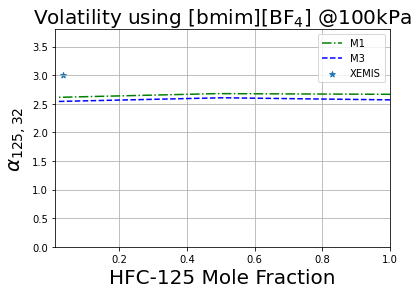

In [11]:
alpha1 = np.zeros(len(R125_z))
alpha2 = np.zeros(len(R125_z))
# alpha3 = np.zeros(len(R125_z))

for i in range(len(R125_z)):
    alpha1[i] = (R125_y[i]/R125_x[i])/(R32_y[i]/R32_x[i])
    alpha2[i] = (R125_y2[i]/R125_x2[i])/(R32_y2[i]/R32_x2[i])
#     alpha3[i] = (R125_y3[i]/R125_x3[i])/(R32_y3[i]/R32_x3[i])


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.title('Volatility using [bmim][BF$_4$] @100kPa',fontsize=20)
plt.ylabel(r'$\alpha_{125,32}$',fontsize=20)
plt.xlabel('HFC-125 Mole Fraction',fontsize=20)
plt.grid(True)
plt.plot(R125_x/0.064,alpha1,"g-.",label="M1")
plt.plot(R125_x2/0.071,alpha2,"b--",label="M3")
plt.scatter([0.032],[3.0011],marker="*",label="XEMIS")
# plt.plot(R125_x3/0.02625086,alpha3,"r",label="Binary T dep")
plt.ylim(0,3.8)
plt.xlim(0.01,1)
plt.legend()
plt.savefig('Vol_[bmim][BF4]_100.png', bbox_inches='tight',dpi=300)
plt.show()


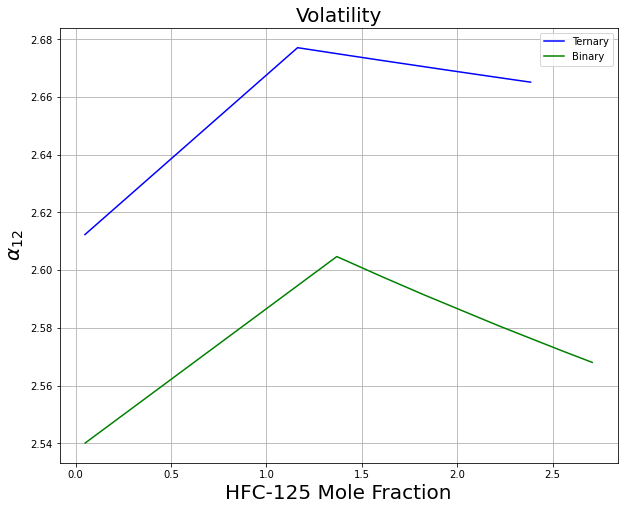

In [7]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)

plt.title('Volatility',fontsize=20)
plt.ylabel(r'$\alpha_{12}$',fontsize=20)
plt.xlabel('HFC-125 Mole Fraction',fontsize=20)
plt.grid(True)
plt.plot(R125_x/0.02687632,alpha1,"b",label="Ternary")
plt.plot(R125_x2/0.02625086,alpha2,"g",label="Binary")
# plt.plot(R125_x3/0.02625086,alpha3,"r",label="Binary T dep")
# plt.ylim(2.8,3.8)
# plt.xlim(0.1,1)
plt.legend()

plt.show()

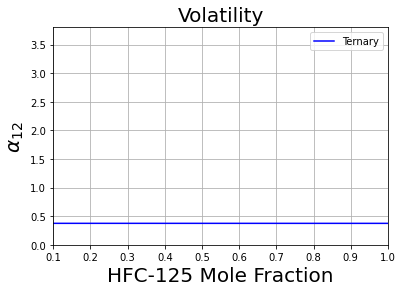

In [8]:
alpha12 = np.zeros(len(R125_z))
alpha22 = np.zeros(len(R125_z))
alpha32 = np.zeros(len(R125_z))

for i in range(len(R125_z)):
    alpha12[i] = (R32_y[i]/R32_x[i])/(R125_y[i]/R125_x[i])
    alpha22[i] = (R32_y2[i]/R32_x2[i])/(R125_y2[i]/R125_x2[i])
#     alpha32[i] = (R32_y3[i]/R32_x3[i])/(R125_y3[i]/R125_x3[i])



plt.title('Volatility',fontsize=20)
plt.ylabel(r'$\alpha_{12}$',fontsize=20)
plt.xlabel('HFC-125 Mole Fraction',fontsize=20)
plt.grid(True)
plt.plot(R32_x/0.02625086,alpha12,"b",label="Ternary")
# plt.plot(R32_x2/0.02625086,alpha22,"g",label="Binary")
# plt.plot(R32_x3/0.02625086,alpha32,"r",label="Binary T dep")
plt.ylim(0,3.8)
plt.xlim(0.1,1)
plt.legend()

plt.show()

In [9]:
print(R32_x)
print(R32_y)
print(R125_x)
print(R125_y)

[0.00097396 0.00992652 0.03125448 0.05533795 0.06892933 0.08409529
 0.12869999]
[0.00566886 0.05792239 0.18347951 0.32710185 0.40903247 0.50121457
 0.97429114]
[0.06410042 0.06055015 0.05210496 0.0425906  0.03723167 0.03126092
 0.0013    ]
[0.99433114 0.94207761 0.81652049 0.67289815 0.59096753 0.49878543
 0.02570886]
